# Hypothesis testing for US Health Insurance Dataset

Shenyue Jia

In [3]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy
scipy.__version__

'1.9.3'

## Data

US Health Insurance Dataset from [Kaggle](https://www.kaggle.com/teertha/ushealthinsurancedataset)

In [4]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)

In [33]:
# inspect data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Do smokers have higher insurance charges than non-smokers? 

### 1.1 State your Null Hypothesis and Alternative Hypothesis

- Null Hypothesis ($H_0$)
    - Smokers do not have a higher insurance charge than non-smokers.
- Alternative Hypothesis ($H_1$)
    - Smokers have a significantly different level of (higher) insurance charge than non-smokers.

### 1.2 Select the correct test according to the data type and number of samples

- Type of Data
    - `charges` column is numeric data
- How many groups/samples?
    - 2 groups (smokers vs. non-smokers)
- Therefore, which test is appropriate?
    - 2 sample t test

### 1.3 Test the assumptions of your selected test

In [34]:
## Drop null values from related columns
df = df.dropna(subset=['smoker','charges'])

In [35]:
# Add an id field as index
ids = list(range(0,df.shape[0]))
df['id'] = ids

# set id as index
df = df.set_index('id')
df.head()

,age,sex,bmi,children,smoker,region,charges
id,,,,,,,
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [36]:
## save list of columns needed for each group
needed_cols = ['smoker','charges']
df[needed_cols]

,smoker,charges
id,,
0,yes,16884.92400
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520
...,...,...
1333,no,10600.54830
1334,no,2205.98080
1335,no,1629.83350


In [37]:
## save male team in separate variable
sm_df = df.loc[ df['smoker']=='yes', needed_cols]
nsm_df = df.loc[ df['smoker']=='no', needed_cols]

In [38]:
## Make a df just for visualization by concat the groups 
plot_df =  pd.concat([sm_df,nsm_df])
plot_df

,smoker,charges
id,,
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768
...,...,...
1332,no,11411.6850
1333,no,10600.5483
1334,no,2205.9808


<AxesSubplot: xlabel='smoker', ylabel='charges'>

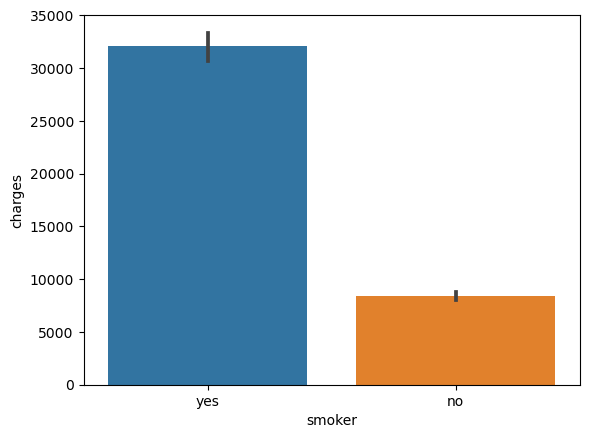

In [39]:
## visualize the group means
sns.barplot(data=plot_df, y='charges',x='smoker')

- From the bar plot, we can find these two groups have a great difference in insurance charges
- We may reject the $H_0$

### 1.4 Execute the selected test

#### Remove outliers

In [40]:
## Saving JUST the numeric col as final group variables
sm_group = sm_df['charges']
nsm_group = nsm_df['charges']
sm_group

id
0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64

In [41]:
## Check smoker group for outliers
sm_outliers = np.abs(stats.zscore(sm_group)) > 3
sm_outliers.sum()

0

In [42]:
## Check non-smoker group for outliers
nsm_outliers = np.abs(stats.zscore(nsm_group)) > 3
nsm_outliers.sum()

24

In [43]:
## remove outliers from non-smoker group
nsm_group = nsm_group.loc[~nsm_outliers]
nsm_group

id
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

In [44]:
# check how many outliers were removed
len(nsm_df),len(nsm_group)

(1064, 1040)

#### Test normality

<AxesSubplot: xlabel='charges', ylabel='Density'>

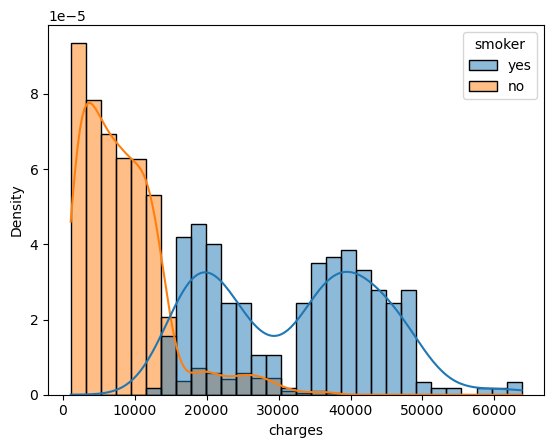

In [49]:
## Make figure and plot histogram
## visualize the histobram of charges by smokers
sns.histplot(data=df, x='charges',hue='smoker',common_norm=False, 
             stat='density',kde=True)

In [51]:
## Check smoker group for normality
result = stats.normaltest(sm_group)
alpha = .05

if result.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nData does not come from a normal distribution.")
else:
    print("The null hypothesis cannot be rejected. \nData comes from a normal distribution")

The null hypothesis can be rejected. 
Data does not come from a normal distribution.


In [53]:
## Check n for smoker group
len(sm_group)

274

In [52]:
## Check non-smoker group for normality
result = stats.normaltest(nsm_group)
alpha = .05

if result.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nData does not come from a normal distribution.")
else:
    print("The null hypothesis cannot be rejected. \nData comes from a normal distribution")

The null hypothesis can be rejected. 
Data does not come from a normal distribution.


In [54]:
len(nsm_group)

1040

- p-values for normality test of both smoker group and non-smoker group are < 0.05
    - Reject the $H_0$ for normality test (data come from a normal distribution)
- Data of smoker group and non-smoker group **DOS NOT** come from a normal distribution
- Our group sizes (n) are large enough (> 15 per group), we can safely ignore the normality assumption.

#### Test for equal variance

In [55]:
## Use Levene's test for equal variance
result = stats.levene(sm_group, nsm_group)
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [56]:
## Use an if-else to help interpret the p-value
## Use an if-else to help interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

The groups do NOT have equal variance.


### 1.5 Final hypothesis test

From the above tests, we know
- Both groups do not follow a normal distribution but our sample size is large enough to ignore the normality test result
- Groups do **NOT** have equal variance
    - **Use a Welch's T-Test**

In [58]:
result = stats.ttest_ind(sm_group, nsm_group, equal_var=False)
print(result)

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


In [59]:
alpha = 0.05
if result.pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. \nMedical insurance of smokers is significantly different from non-smokers.")
else:
    print("The null hypothesis cannot be rejected. \nMedical insurance of smokers is **NOT** significantly different from non-smokers")

The null hypothesis can be rejected. 
Medical insurance of smokers is significantly different from non-smokers.


### 1.6 Understand the result

<AxesSubplot: xlabel='smoker', ylabel='charges'>

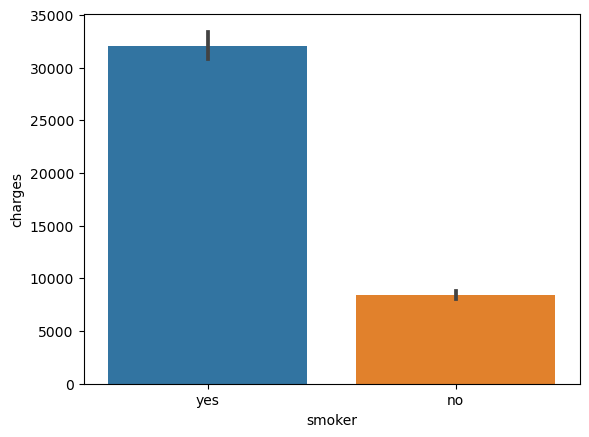

In [60]:
## visualize the group means
sns.barplot(data=plot_df, y='charges',x='smoker')

<AxesSubplot: xlabel='charges', ylabel='Density'>

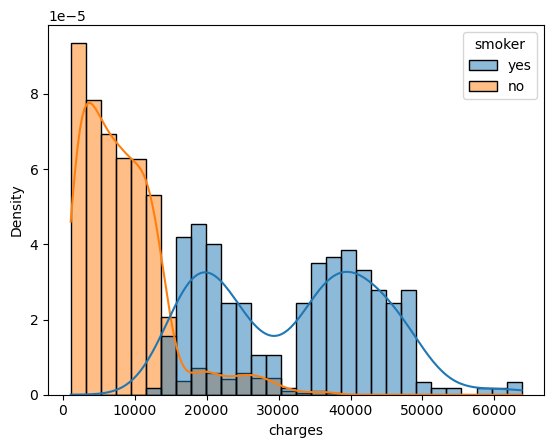

In [61]:
## visualize the histobram of charges by smokers
sns.histplot(data=df, x='charges',hue='smoker',common_norm=False, 
             stat='density',kde=True)

- The above visualizations and the t-test results indicate that:
    - Smokers have a signficantly different medical insurance charge than non-smokers
    - Medical insurance charges for smokers are **higher** than non-smokers

## 2. Are men more likely to smoke than women?

### 2.1 State your Null Hypothesis and Alternative Hypothesis

- Null Hypothesis ($H_0$)
    - Men are not more likely to smoke than women.
- Alternative Hypothesis ($H_1$)
    - Men have a significantly different chance of (higher) to smoke than women.

### 2.2 Select the correct test according to the data type and number of samples

- Type of Data
    - `sex` column is categorical data
- How many groups/samples?
    - 2 groups (men vs. women)
- Therefore, which test is appropriate?
    - Chi-square test

### 2.3 Test the assumptions of your selected test

In [5]:
## Drop null values from related columns
df = df.dropna(subset=['smoker','sex'])

In [6]:
# Add an id field as index
ids = list(range(0,df.shape[0]))
df['id'] = ids

# set id as index
df = df.set_index('id')
df.head()

,age,sex,bmi,children,smoker,region,charges
id,,,,,,,
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
## save list of columns needed for each group
needed_cols = ['smoker','sex']
df[needed_cols]

,smoker,sex
id,,
0,yes,female
1,no,male
2,no,male
3,no,male
4,no,male
...,...,...
1333,no,male
1334,no,female
1335,no,female


In [37]:
## save male team in separate variable
sm_df = df.loc[ df['smoker']=='yes', needed_cols]
nsm_df = df.loc[ df['smoker']=='no', needed_cols]

In [38]:
## Make a df just for visualization by concat the groups 
plot_df =  pd.concat([sm_df,nsm_df])
plot_df

,smoker,charges
id,,
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768
...,...,...
1332,no,11411.6850
1333,no,10600.5483
1334,no,2205.9808


<AxesSubplot: xlabel='smoker', ylabel='charges'>

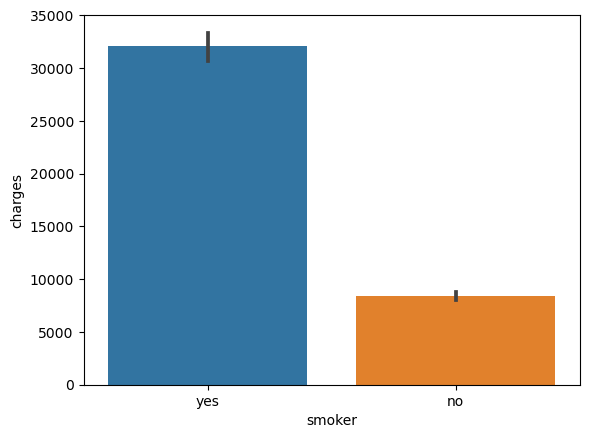

In [39]:
## visualize the group means
sns.barplot(data=plot_df, y='charges',x='smoker')